In [1]:
import IPython
import sys
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

In [2]:
#Improting data (same for everyone)
data_path = "./data/"
subscriptions = pd.read_csv(data_path + 'subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv(data_path + 'visitationdataPART1.csv') 
visitation_part2 = pd.read_csv(data_path + 'visitationdataPART2.csv') #convert the join and end date to_date
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)

In [3]:
#creating copy of dataset
subscriptions_jiaqi= subscriptions.copy()
visitation_part1_jiaqi= visitation_part1.copy()
visitation_part2_jiaqi= visitation_part2.copy()

In [4]:
#Calculating active members
def active_members(subscriptions_jiaqi):
    date_min = min (subscriptions_jiaqi['Join Date'].min(),subscriptions_jiaqi['End Date'].min() )
    date_max = max (subscriptions_jiaqi['Join Date'].max(),subscriptions_jiaqi['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    subscriptions_jiaqi['End Date'] = subscriptions_jiaqi['End Date'].fillna(date_max)
    subscriptions_jiaqi[all_dates] = pd.concat([((subscriptions_jiaqi['Join Date'] <= i) & (i <= subscriptions_jiaqi['End Date'])).astype(int) for i in all_dates], axis=1)
    return subscriptions_jiaqi

## Duration analysis Graph  by year

In [5]:
#Calculation of Duration
def duration_calc(subscriptions_jiaqi):
    date_min = min (subscriptions_jiaqi['Join Date'].min(),subscriptions_jiaqi['End Date'].min() )
    date_max = max (subscriptions_jiaqi['Join Date'].max(),subscriptions_jiaqi['End Date'].max() )
    dates = pd.date_range(date_min, date_max, freq = 'MS')
    subscriptions_jiaqi['Duration'] = np.where(subscriptions_jiaqi['End Date'].isna(), 
                                           (date_max - subscriptions_jiaqi['Join Date']), 
                                           (subscriptions_jiaqi['End Date'] - subscriptions_jiaqi['Join Date']) )
    subscriptions_jiaqi['Duration'] = (subscriptions_jiaqi['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
    duration= subscriptions_jiaqi.groupby(['Join Date', 'Duration']).size().to_frame('Count').reset_index()
    return duration

In [6]:
#Duration distribution by year graph
def duration_dis_plot():
    duration= duration_calc(subscriptions_jiaqi)
    duration['year']=duration['Join Date'].dt.year
    sns.displot(duration, x="Duration",kde=True, col='year',col_wrap=5)
    plt.title('Duration Distribution by year')
    plt.show()

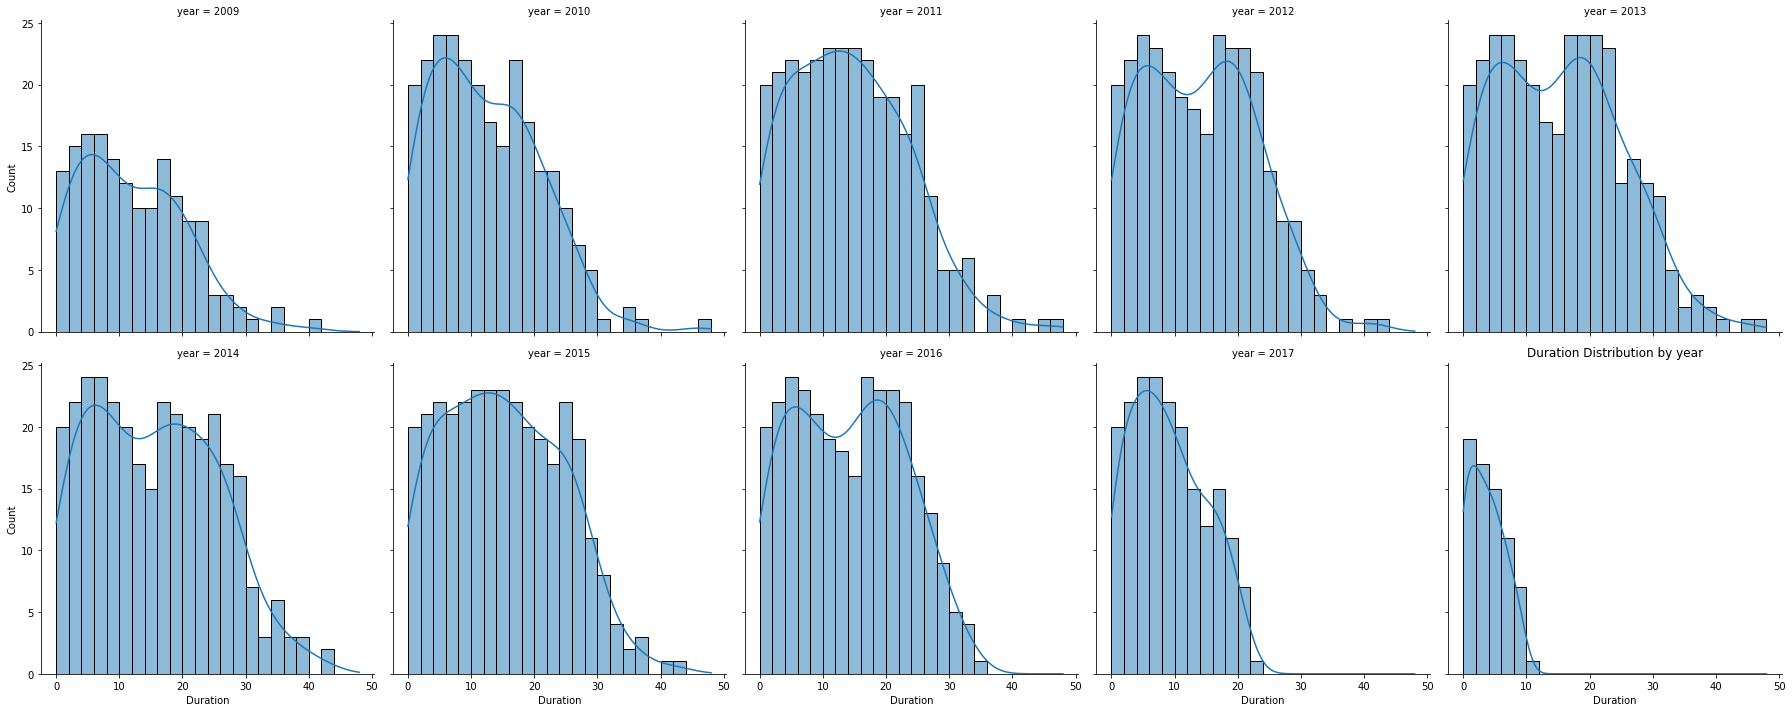

In [7]:
duration_dis_plot()

## Duration analysis by affluence graph

In [8]:
def duration_affluence_plot():
    duration= duration_calc(subscriptions_jiaqi)
    duration= subscriptions_jiaqi.groupby(['Join Date', 'Duration','Affluence']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",col= "Affluence",hue='Affluence',col_wrap=3,kind="kde", fill=True)

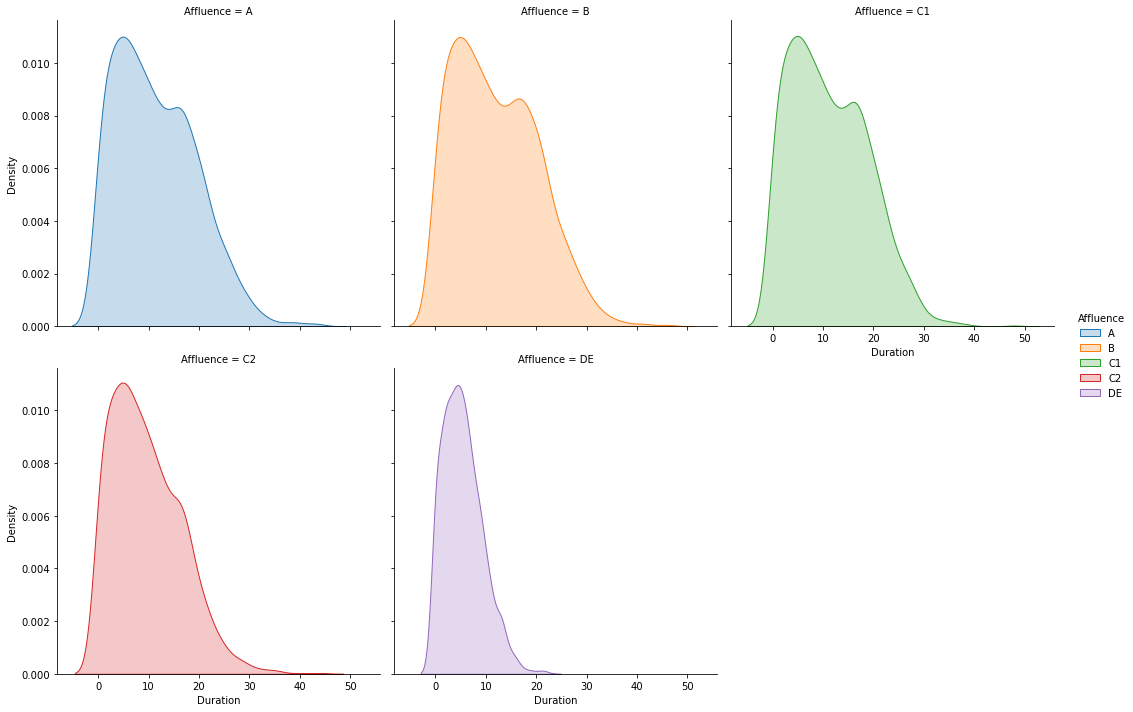

In [9]:
duration_affluence_plot()

### Duration Analysis by gender

In [10]:
def duration_gender_plot():
    duration= duration_calc(subscriptions_jiaqi)
    duration= subscriptions_jiaqi.groupby(['Join Date', 'Duration','Gender']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",hue='Gender',kind="kde", fill=True)
    plt.title('Duration Distribution by Gender')

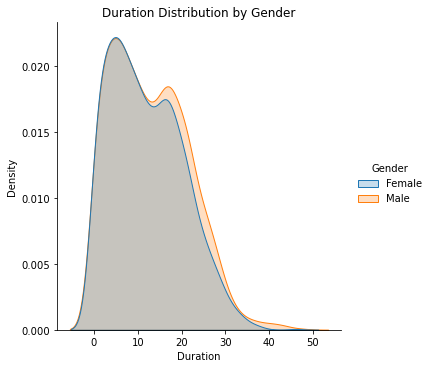

In [11]:
duration_gender_plot()

## Duration Analysis by Subscription Type

In [12]:
def duration_subscription_type_plot():
    duration= duration_calc(subscriptions_jiaqi)
    duration= subscriptions_jiaqi.groupby(['Join Date', 'Duration','Subscription Type']).size().to_frame('Count').reset_index()
    sns.displot(duration, x="Duration",hue='Subscription Type',kind="kde", fill=True)
    plt.title('Duration Distribution by Subscription Type')

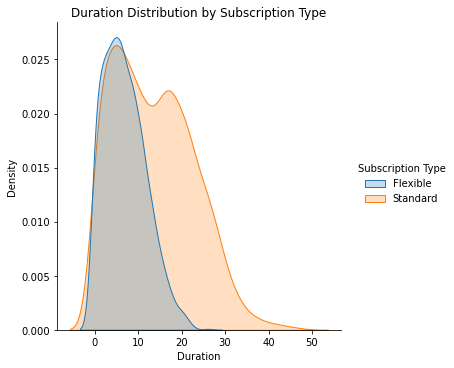

In [13]:
duration_subscription_type_plot()

## Monthly visitations by season

In [14]:
#Merging the visitation and subscriptions data together
def merging_data():
    visit1_jiaqi=visitation_part1.copy()
    visit2_jiaqi=visitation_part2.copy()
    visitdf = pd.concat([visit1_jiaqi, visit2_jiaqi], axis=0, join='inner')
    all_data= pd.merge( left= subscriptions_jiaqi, right= visitdf, left_on='CustomerID', right_on='CustomerID')
    all_data['visitdate'] =  pd.to_datetime(all_data['visitdate'].str.upper(), format='%d/%m/%Y', yearfirst=False)
    all_data['month'] = all_data['visitdate'].dt.month
    return all_data

In [15]:
#Classifying season
def classify_season(month):
    if  month==6 or month==7 or month==8:
        return 'Summer'
    elif month==9 or month==10 or month==11:
        return 'Autumn'
    elif month==12 or month==1 or month==2:
        return 'winter'
    else:
        return 'Spring'

In [16]:
# Plot for monthly visitations by season:
def plot_season():
    all_data = merging_data()
    all_data['Season'] = all_data['month'].apply(lambda x : classify_season(x))
    freq=all_data.groupby(['CustomerID','month','Season']).size().to_frame('Monthly Visits').reset_index()
    sns.displot(freq, x="Monthly Visits",hue='Season',kind="kde", bw_adjust=1.5, fill=True)
    plt.title('Monthly Visitation Distribution by Season')

In [ ]:
plot_season()

## Customer Profile

In [ ]:
#Classigying age
def classify_age(age):
    if   18 <=age<=24:
        return '18-24'
    elif 25<= age <=30:
        return '25-30'
    elif 31 <= age <= 40:
        return '31-40'
    else:
        return '41-60'

#Data for plotting active members by age 
def customer_age_data():
    df= active_members(subscriptions_jiaqi)
    df['age'] = df['join_year'] - df['BirthYear']   
    df['agerange'] = df['age'].apply(lambda x : classify_age(x))
    date_min = min (subscriptions_jiaqi['Join Date'].min(),subscriptions_jiaqi['End Date'].min() )
    date_max = max (subscriptions_jiaqi['Join Date'].max(),subscriptions_jiaqi['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_age=df.groupby('agerange')[all_dates].sum().T
    df_age1=df_age.reset_index()
    df_age1['year'] = df_age1['index'].dt.year
    df_age2=df_age1.drop(columns=('index'), axis=1)
    plot_age=df_age2.set_index('year')
    plot_age['age:18-24']=plot_age['18-24'] / plot_age.sum(axis=1)
    plot_age['age:25-30']=plot_age['25-30'] / plot_age.sum(axis=1)
    plot_age['age:31-40']=plot_age['31-40'] / plot_age.sum(axis=1)
    plot_age['age:41-60']=plot_age['41-60'] / plot_age.sum(axis=1)
    return plot_age

# active members by age plot
def customer_age_plot():
    plot_age= customer_age_data()
    plot_age.loc[:,['age:18-24','age:25-30','age:31-40', 'age:41-60']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by age')

In [ ]:
customer_age_plot()

In [ ]:
#Data for plotting active members by Gender:
def customer_gender_data():
    df=active_members(subscriptions_jiaqi)
    date_min = min (subscriptions_jiaqi['Join Date'].min(),subscriptions_jiaqi['End Date'].min() )
    date_max = max (subscriptions_jiaqi['Join Date'].max(),subscriptions_jiaqi['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_g=df.groupby('Gender')[all_dates].sum().T
    df_g1=df_g.reset_index()
    df_g1['year'] = df_g1['index'].dt.year
    df_g2=df_g1.drop(columns=('index'), axis=1)
    plot_g=df_g2.set_index('year')
    plot_g['female']=plot_g['Female'] / plot_g.sum(axis=1)
    plot_g['male']=plot_g['Male'] / plot_g.sum(axis=1)
    return plot_g


# active members by gender plot
def customer_gender_graph():
    plot_g= customer_gender_data()
    plot_g.loc[:,['female','male']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by Gender')

In [ ]:
customer_gender_graph()

In [ ]:
# active members by afflunce plot:
def customer_affluence_data():
    df=active_members(subscriptions_jiaqi)
    date_min = min (subscriptions_jiaqi['Join Date'].min(),subscriptions_jiaqi['End Date'].min() )
    date_max = max (subscriptions_jiaqi['Join Date'].max(),subscriptions_jiaqi['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_a=df.groupby('Affluence')[all_dates].sum().T
    df_a1=df_a.reset_index()
    df_a1['year'] = df_a1['index'].dt.year
    df_a2=df_a1.drop(columns=('index'), axis=1)
    plot_a=df_a2.set_index('year')
    plot_a['a']=plot_a['A'] / plot_a.sum(axis=1)
    plot_a['b']=plot_a['B'] / plot_a.sum(axis=1)
    plot_a['c1']=plot_a['C1'] / plot_a.sum(axis=1)
    plot_a['c2']=plot_a['C2'] / plot_a.sum(axis=1)
    plot_a['de']=plot_a['DE'] / plot_a.sum(axis=1)
    return plot_a

def customer_affluence_graph():
    plot_a= customer_affluence_data()
    plot_a.loc[:,['a','b','c1','c2','de']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by Affluence')


In [ ]:
customer_gender_graph()

In [ ]:
# active members by subscription type plot:
def customer_sub_type_data():
    df=active_members(subscriptions_jiaqi)
    date_min = min (subscriptions_jiaqi['Join Date'].min(),subscriptions_jiaqi['End Date'].min() )
    date_max = max (subscriptions_jiaqi['Join Date'].max(),subscriptions_jiaqi['End Date'].max() )
    all_dates = pd.date_range(date_min, date_max, freq = 'Y')
    df_c=df.groupby('Subscription Type')[all_dates].sum().T
    df_c1=df_c.reset_index()
    df_c1['year'] = df_c1['index'].dt.year
    df_c2=df_c1.drop(columns=('index'), axis=1)
    plot_c=df_c2.set_index('year')
    plot_c['standard']=plot_c['Standard'] / plot_c.sum(axis=1)
    plot_c['flexible']=plot_c['Flexible'] / plot_c.sum(axis=1)
    return plot_c


# active members by subscriptiontype plot
def customer_sub_type_graph():
    plot_c= customer_sub_type_data()
    plot_c.loc[:,['standard','flexible']].plot.bar(stacked=True, figsize=(10,7))
    leg = plt.legend( loc = 'upper right')
    plt.title('Active Members by Subscription Type')

In [ ]:
customer_sub_type_graph()

## Seasonality Analysis graphs

In [ ]:
#Data for seasonal cancellations
def cancellations_season_data(subscriptions_jiaqi):
    df= active_members(subscriptions_jiaqi)
    df['month'] = pd.DatetimeIndex(df['End Date']).month
    df['year'] = pd.DatetimeIndex(df['End Date']).year
    df['Season'] = df['month'].apply(lambda x : classify_season(x))
    season=df.groupby(['year','Season']).size().to_frame('Cancellations').reset_index()
    season1= season.groupby(['Season']).sum().reset_index()
    return season1

#seasonal cancellations plot
def seasonal_cancellations_plot():
    season1= cancellations_season_data(subscriptions_jiaqi)
    season1.plot.bar(x='Season', y='Cancellations')
    plt.title('Membership Cancellations by Season')


In [ ]:
seasonal_cancellations_plot()

In [ ]:
#Data for seasonal new members
def new_membership_season_data(subscriptions_jiaqi):
    df= active_members(subscriptions_jiaqi)
    df['month'] = pd.DatetimeIndex(df['Join Date']).month
    df['year'] = pd.DatetimeIndex(df['Join Date']).year
    df['Season'] = df['month'].apply(lambda x : classify_season(x))
    season=df.groupby(['year','Season']).size().to_frame('New members').reset_index()
    season1= season.groupby(['Season']).sum().reset_index()
    return season1

#seasonal new members plot
def seasonal_new_memberships_plot():
    season1= new_membership_season_data(subscriptions_jiaqi)
    season1.plot.bar(x='Season', y='New members')
    plt.title('New memberships by Season')

In [ ]:
seasonal_new_memberships_plot()

### Number of clubs overitme

In [ ]:
def number_of_clubs():
    df=active_members(subscriptions_jiaqi)
    df['year'] = df['Join Date'].dt.year
    df11=df.groupby(['Club','year']).size().to_frame('Count').reset_index()
    df_club=df11.groupby(['Club','year']).size().to_frame('Count').reset_index()
    pivotdata = df_club.pivot(index= 'year', columns='Club', values='Count')
    pivotdata["sum"] = pivotdata.sum(axis=1)
    plotdata=pivotdata.reset_index()
    return plotdata

def club_plot():
    plotdata= number_of_clubs()
    plotdata.plot.bar(x='year', y='sum', figsize=(10,7))
    plt.title('Number of Clubs Over Time')

In [ ]:
club_plot()